In [3]:
import pandas as pd
import numpy as np
# Load the data
df = pd.read_csv('bank-full.csv', sep=';')  


# Select only required columns
columns_to_use  = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df = df[columns_to_use]

print(df)

       age           job   marital  education  balance housing    contact  \
0       58    management   married   tertiary     2143     yes    unknown   
1       44    technician    single  secondary       29     yes    unknown   
2       33  entrepreneur   married  secondary        2     yes    unknown   
3       47   blue-collar   married    unknown     1506     yes    unknown   
4       33       unknown    single    unknown        1      no    unknown   
...    ...           ...       ...        ...      ...     ...        ...   
45206   51    technician   married   tertiary      825      no   cellular   
45207   71       retired  divorced    primary     1729      no   cellular   
45208   72       retired   married  secondary     5715      no   cellular   
45209   57   blue-collar   married  secondary      668      no  telephone   
45210   37  entrepreneur   married  secondary     2971      no   cellular   

       day month  duration  campaign  pdays  previous poutcome    y  
0    

In [4]:
df.isnull().sum() 

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [10]:
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [11]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']


In [12]:
numerical = df.select_dtypes(include=[np.number]).columns.tolist()
numerical.pop(-1)
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [13]:
categorical =  df.select_dtypes(include=[object]).columns.tolist()
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0,max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8974784339747843

In [16]:
# Question 1: ROC AUC feature importance
# ROC AUC could also be used to evaluate feature importance of numerical variables.

auc_scores = {}
for i in numerical:
    auc_score = roc_auc_score(y_train, df_train[i])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[i])
    print('%9s, %.5f' % (i, auc_score))
    auc_scores[i] = auc_score

      age, 0.51219
  balance, 0.58883
      day, 0.52596
 duration, 0.81470
 campaign, 0.57145
    pdays, 0.59013
 previous, 0.59857


In [17]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# What's the AUC of this model on the validation dataset? (round to 3 digits)
y_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(round(auc_score,3))

0.901


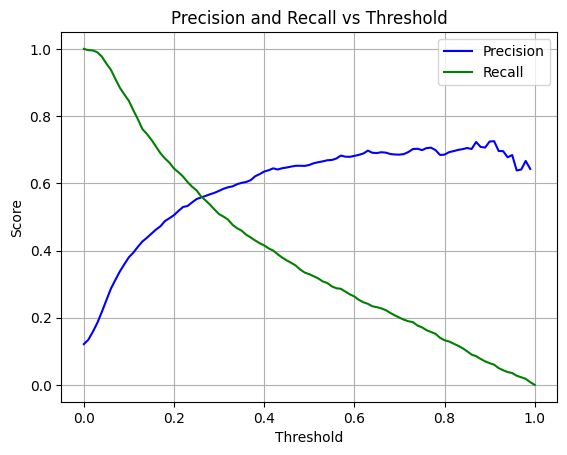

Precision and Recall curves intersect at threshold: 0.260


In [20]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?


from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
# Plot Precision and Recall
plt.figure()
plt.plot(df_scores['threshold'], df_scores['p'], label='Precision', color='blue')
plt.plot(df_scores['threshold'], df_scores['r'], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Find the intersection point where precision equals recall
intersection_point = df_scores[np.isclose(df_scores['p'], df_scores['r'], atol=0.01)]
if not intersection_point.empty:
    print(f"Precision and Recall curves intersect at threshold: {intersection_point['threshold'].values[0]:.3f}")
else:
    print("Precision and Recall curves do not intersect within the given tolerance.")

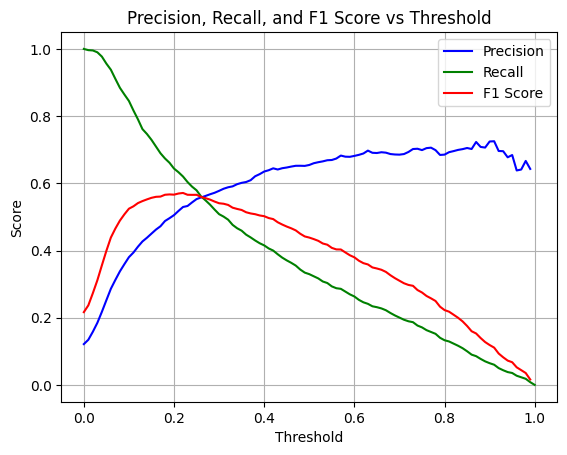

F1 score is maximal at threshold: 0.220 with F1 score: 0.571


In [21]:
# Calculate F1 score (handling cases where precision + recall == 0)
df_scores['f1'] = 2 * (df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r']).replace(0, np.nan)

# Plot Precision, Recall, and F1 Score
plt.figure()
plt.plot(df_scores['threshold'], df_scores['p'], label='Precision', color='blue')
plt.plot(df_scores['threshold'], df_scores['r'], label='Recall', color='green')
plt.plot(df_scores['threshold'], df_scores['f1'], label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Find the threshold where F1 score is maximal
max_f1_row = df_scores.loc[df_scores['f1'].idxmax()]
max_f1_threshold = max_f1_row['threshold']
max_f1_value = max_f1_row['f1']

print(f"F1 score is maximal at threshold: {max_f1_threshold:.3f} with F1 score: {max_f1_value:.3f}")

KeyError: "['y'] not found in axis"